# get flux

In [1]:
import pandas as pd
import itertools
import cobra
from typing import Dict, List
from collections import defaultdict

E0 = cobra.io.read_sbml_model("./models/iML1515_E0.xml")
gene_pathway_df = pd.read_csv('./Data/gene_pathway.csv')
desired_cycle = pd.read_csv('./Data/desired_cycle.csv', index_col=0) #flux analysis.ipynb
# gr_DG = pd.read_csv('./r/data fitting/standardized_gr_Div_DG_Mult_Aug31.csv', index_col='gene_inhibition')
rct_pathway_df = pd.read_csv('./Data/rct_pathway.csv')
alpha_table = pd.read_csv('./Data/alpha_table.csv', index_col='Gene_inhibition')


In [32]:
from itertools import chain

In [9]:
alpha_table = pd.read_csv('./Data/alpha_table.csv', index_col='Gene_inhibition')
p_o = pd.read_csv('./Data/pair_pathway_drug_effect.csv', index_col=0)

In [11]:
def convert_arg_to_list(arg):
    if type(arg) is not list and type(arg) is not tuple:
        arg = [arg]
    return(arg)

def get_Biomass_df(files):
    return pd.concat(
            [pd.read_csv(file, index_col='cycle')
             for file in convert_arg_to_list(files)]
        ,axis=1)

Biomass_df = get_Biomass_df(['./Data/BM_SG1.csv', './Data/BM_DG1.csv'])

In [12]:
def get_gene_id(model, gene_name):
    for i in model.genes:
        if(i.name == gene_name):
            return(i.id)

def get_rcts_list(gcomb_list): 
    rcts_list = list()
    rcts_set = set()
    for i, gene in enumerate(gcomb_list):
        gene_rcts = [rct.id for rct in E0.genes.get_by_id(get_gene_id(E0, gene)).reactions]
        if i > 0:
            gene_rcts = list(set(gene_rcts) - rcts_set)
        rcts_list.append(gene_rcts)
        rcts_set = rcts_set | set(gene_rcts)
    return rcts_list

def adjust_flux_df(df, gene_combo: list):
    if 'Normal' not in gene_combo:
#         gene_combo_dict = get_gcomb_alpha_dict(gene_combo) 
        v1_cols = df.filter(regex='v1').columns
        orig_cols = [ele.replace("_v1", '') for ele in df.filter(regex='v1').columns]
        
        gene_combo_list = gene_combo.split('.')
        rcts_list = get_rcts_list(gene_combo_list)
        scaled_rcts = list()
        for gene, rcts in zip(gene_combo_list, rcts_list):  
            rcts = [rct for rct in rcts if rct in orig_cols]
            for orig_col in rcts:
                alpha = alpha_table.loc[f'{gene}', 'E0']   
                v1_col = orig_col + "_v1"
                df[f'{orig_col}'] = (df[f'{orig_col}'] + df[f'{v1_col}'])/alpha # only forward or backward != 0               
                df = df.drop(f'{v1_col}', axis=1) 
#     print(df.filter(regex='v1').columns)
    return df

def get_desired_BM(Biomass_df = Biomass_df, regex='Normal_coculture'):
    return Biomass_df.filter(regex=regex)

In [13]:
# compare_df = compare_df.rename_axis('Reactions').reset_index()

def get_row_grmax(desired_BM, genes='Normal'): # currently only E0
    desired_cycle = find_down_neighbour(desired_BM)
    dfE = analysis_df.loc[genes, 'E0_coculture_flux']
#     dfE = remove_Zero_col(pd.read_json(dfE). # no use 
    dfE = (pd.read_json(dfE). 
           query("cycle in @desired_cycle").
           drop(['x','y','cycle'], axis=1))
    dfE.index = [genes]
    
    return dfE

def get_genes_compare(gene_list, Biomass_df, regex): # generate every gene-> subset
    desired_BM = get_desired_BM(Biomass_df, regex=regex)
    compare_list = list()
    for genes in gene_list:

        temp_df = get_row_grmax(desired_BM, genes=genes) # for flux only
        """
        If ~ == flux/ not metabo
        """    
        temp_df = adjust_flux_df(temp_df, genes)
        compare_list.append(temp_df)
        
    compare_df = (remove_Zero_col(pd.concat(compare_list)).T. # row to column
                  sort_values(by='Normal', key=abs, ascending=False)) # with 0 cell
    return compare_df

def get_abs_df(df):
    return (pd.DataFrame({colname: abs(col) for colname, col in df.items()}).
                  rename_axis('Reactions').
                  reset_index())

In [14]:
def supply_line(file):
#     file = f'./Data/{file}'
    with open(file) as fh:
        for line in fh:
            yield json.loads(line) 
            
def retrive_specific_culture(file, culture_key):
#     culture_key = 'E0_coculture_flux'
    supp = supply_line(file)
    flux_dict = dict()
    for line in supp:    # culture as column <=> keys
        culture_dict = line.get(f'{culture_key}')
        if culture_dict:
            return culture_dict

def retrive_specific_keys(file, culture_key, genes_dict: Dict[str, int]):
    
    def get_flux_dict(culture_dict, genes_dict):
        flux_dict, no_grow= dict(), list()
        for current_gene_combo, cycle in genes_dict.items():
            if cycle < 15:
                no_grow.append(current_gene_combo)
                flux_dict[current_gene_combo] = pd.DataFrame([], index = [f'{current_gene_combo}'])
            else:
                desired_js = culture_dict.get(f'{current_gene_combo}')
                temp_df = pd.read_json(desired_js).query("cycle == @cycle")
                temp_df.index = [current_gene_combo]
    #                 return temp_df, current_gene_combo
                flux_dict[current_gene_combo] = adjust_flux_df(temp_df, current_gene_combo) # df as 
#             genes_dict = {current_gene_combo: genes_dict.get(f'{current_gene_combo}') for current_gene_combo in genes_dict}  #subset of gene
        if no_grow:
            print('Zero growth: ', ', '.join(no_grow))
        return pd.concat(flux_dict.values()) # pd.read_json() culture_key -> col pd.read_json()
    
    if type(file) is dict:
        return get_flux_dict(file, genes_dict)
    else:
        culture_dict = retrive_specific_culture(file, culture_key)
        return get_flux_dict(culture_dict, genes_dict) 
    
def query_desired_cycle(cgc_list: list):
    return {gcomb: desired_cycle[gcomb] for gcomb in cgc_list}
# pwy group with more than 2 element
def get_pwypair_gp_GRT2(p_o: dict): # index greater than 2 element
    flux_compare_combos_dict = {k:v for k,v in p_o.items() if len(v)>=2}
    return flux_compare_combos_dict


In [15]:
def retrive_specific_keys(file, culture_key, desired_cycle):
    def get_flux_dict(culture_dict, desired_cycle):
        flux_dict, no_grow= dict(), list()
        for current_gene_combo, cycle in desired_cycle.iterrows():
            cycle = cycle['cycle']
            if cycle < 15:
                no_grow.append(current_gene_combo)
                flux_dict[current_gene_combo] = pd.DataFrame([], index = [f'{current_gene_combo}'])
            else:
                desired_js = culture_dict.get(f'{current_gene_combo}')
                temp_df = pd.read_json(desired_js).query("cycle == @cycle")
                temp_df.index = [current_gene_combo]
        #                 return temp_df, current_gene_combo
                flux_dict[current_gene_combo] = adjust_flux_df(temp_df, current_gene_combo) # df as 
        #             genes_dict = {current_gene_combo: genes_dict.get(f'{current_gene_combo}') for current_gene_combo in genes_dict}  #subset of gene
        if no_grow:
            print('Zero growth: ', ', '.join(no_grow))
        return pd.concat(flux_dict.values()) # pd.read_json() culture_key -> col pd.read_json()
    
    if type(file) is dict:
        return get_flux_dict(file, desired_cycle)
    else:
        culture_dict = retrive_specific_culture(file, culture_key)
        return get_flux_dict(culture_dict, desired_cycle) 
    
def remove_Zero_col(df): # extend N differ than 0 
    return(df.loc[:, (df !=0).any(axis=0)]) 

def clean_flux_df(df):
    return remove_Zero_col(df.dropna())

In [16]:
SG_cycle = desired_cycle.loc[[ele for ele in desired_cycle.index if len(ele.split('.')) ==1]]
DG_cycle = desired_cycle.loc[[ele for ele in desired_cycle.index if len(ele.split('.')) >=2]]
Normal_cycle = SG_cycle.loc[['Normal']]
Normal_df = retrive_specific_keys('./Data/flanalysis_BM_SG.json', 'E0_coculture_flux', Normal_cycle)

In [17]:
culture_dict = retrive_specific_culture('./Data/ccol_DG.json', 'E0_coculture_flux')
flux_compare_df = retrive_specific_keys(culture_dict, 'E0_coculture_flux', DG_cycle)
flux_compare_df = pd.concat([Normal_df, flux_compare_df])
# flux_compare_df.to_csv('./Data/raw_gr_flux.csv')
flux_compare_df = clean_flux_df(flux_compare_df)
flux_compare_df.index.name = 'DG'

Zero growth:  dadX.eno, dadX.gapA, acnB.purT, acnB.ackA


SG flux compare

In [20]:
SG_df = retrive_specific_keys('./Data/flanalysis_BM_SG.json', 'E0_coculture_flux', SG_cycle)
# SG_df.to_csv('./Data/raw_SGgr_flux.csv')
SG_df = clean_flux_df(SG_df)

Zero growth:  gapA, eno, yrbG


In [21]:
exchange_rct = [rct.id for rct in E0.reactions if 'EX_' in rct.id]
CAC_rct = rct_pathway_df.query('Pathway=="Citric Acid Cycle"').Reaction.unique()

In [22]:
def subset_cols_flux_df(reactions: list, flux_compare_df=flux_compare_df):
    return flux_compare_df[[ele for ele in flux_compare_df.columns if ele in reactions]]
exchange_df = subset_cols_flux_df(exchange_rct)
CAC_df = subset_cols_flux_df(CAC_rct)

In [23]:
def subset_cols_flux_df(reactions: list, flux_compare_df=flux_compare_df):
    return flux_compare_df[[ele for ele in flux_compare_df.columns 
                            if ele in reactions]]
exchange_df = subset_cols_flux_df(exchange_rct, SG_df)
CAC_df = subset_cols_flux_df(CAC_rct, SG_df)

In [24]:
def get_large_ac_df(exchange_df,ac_threshold=6):
    return exchange_df.query('EX_ac_e >@ac_threshold | EX_ac_e< -1*@ac_threshold').index
large_ac = get_large_ac_df(exchange_df)

In [25]:
get_large_ac_df(exchange_df, 0.3)

Index(['mrdA', 'dapA', 'pgk', 'gltA'], dtype='object')

In [30]:
def get_high_EX_df(nlargest):
    DG_list = DG_cycle.index
    temp_list = list()
    for current_gene in nlargest:
        temp_list.append([current_gene, exchange_df.loc[current_gene,'EX_ac_e'], [ele for ele in DG_list if current_gene in ele]])
    df = pd.DataFrame.from_records(temp_list,columns=['SG_High_ac_execretion', 'SG_EX_ac_flux', 'DG'])
    return df

def get_nlargest_flux(Reaction: str, n):
    nlargest =  exchange_df[[Reaction]].nlargest(n, columns=Reaction).sort_values(Reaction,ascending=False).index
    return get_high_EX_df(nlargest)
ac_flux_df = get_nlargest_flux('EX_ac_e', len(SG_cycle.index))
DG_ac = [v for v in ac_flux_df.DG.explode().unique() if v==v]


DG_exchange_df = subset_cols_flux_df('EX_ac_e', flux_compare_df).reset_index()

gene_pathway_df = pd.read_csv('./Data/gene_pathway.csv')

(ac_flux_df.explode('DG').merge(DG_exchange_df, on='DG', how='left')
                       .merge(p_o[['Drug_comb_effect']].reset_index(), left_on='DG',
                              right_on='Gene_inhibition', how='left'))

ac_flux_df = (ac_flux_df.explode('DG').merge(DG_exchange_df, on='DG', how='left')
                       .merge(p_o[['Drug_comb_effect']].reset_index(), left_on='DG',
                              right_on='Gene_inhibition', how='left', right_index=False)
                       .merge(gene_pathway_df, left_on='DG',
                              right_on='Gene_inhibition', how='left', right_index=False))
cols = ac_flux_df


In [36]:
def get_ac_flux_df():
    ac_flux_df = get_nlargest_flux('EX_ac_e', len(SG_cycle.index))
    ac_flux_df = (ac_flux_df.explode('DG').merge(DG_exchange_df, on='DG', how='left')
                           .merge(p_o[['Drug_comb_effect']].reset_index(), left_on='DG',
                                  right_on='Gene_inhibition', how='left')
                           .merge(gene_pathway_df[['Gene_inhibition', 'Pathway']], how='left'))
    cols = ac_flux_df.columns
    ac_flux_df = ac_flux_df[list(chain(*[cols[:2], [cols[-1]], cols[2:-1]]))]

    ac_flux_df = get_nlargest_flux('EX_ac_e', len(SG_cycle.index))
    sub_gene_pathway_df = (gene_pathway_df[['Gene_inhibition', 'Pathway']]
     .groupby('Gene_inhibition', as_index=False)
     .agg(Pathway = ('Pathway',lambda x: ' + '.join(x))))

    ac_flux_df = (ac_flux_df.explode('DG').merge(DG_exchange_df, on='DG', how='left')
                           .merge(p_o[['Drug_comb_effect']].reset_index(), left_on='DG',
                                  right_on='Gene_inhibition', how='left')
                           .merge(sub_gene_pathway_df, left_on='SG_High_ac_execretion',
                                  right_on='Gene_inhibition',how='left'))
    cols = ac_flux_df.columns
    ac_flux_df = ac_flux_df[list(chain(*[cols[:2], [cols[-1]], cols[2:-2]]))]
    ac_flux_df['SG_DG_ac_flux_diff'] = ac_flux_df.SG_EX_ac_flux-ac_flux_df.EX_ac_e
    ac_flux_df['Drug_comb_ac_flux_change'] = pd.cut(
        ac_flux_df.SG_DG_ac_flux_diff, bins=[-10,0,10],labels=['Drug_comb_increased_ac_excretion',
                                                                        'Drug_comb_reduced_ac_excretion'])

    ac_flux_df.query('Drug_comb_ac_flux_change == "Drug_comb_increased_ac_excretion"')
    ac_flux_df.to_csv('ac_flux_compare.csv', index=False)
ac_flux_df = get_ac_flux_df()

<AxesSubplot:>

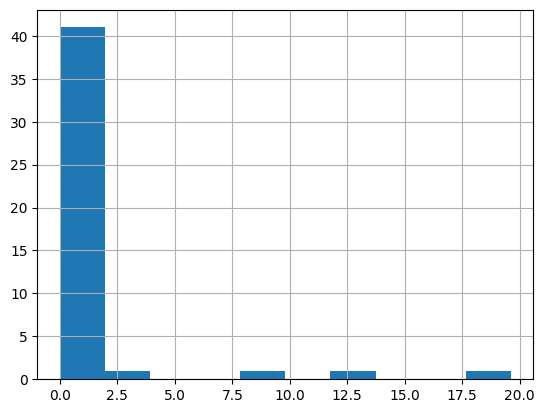

In [113]:
exchange_df.EX_ac_e.hist()